## Set up a duckweed genotypes x media growth assay

### Pre-requisites to use this script
1. Precise plate and well positions for your machine defined in Plate_positions.py in the 'utils' subdirectory. 
2. All the parameters defined in the cell 'User paramters'. 
3. Sufficient 24-well plates, sterile media and duckweed plants available. 
4. Jubilee machine set up with Media-dispensing syringe tool (50 mL), Duckweed transfer syringe tool and lab automation bedplate. 


In [1]:
#Importing python libraries downloaded from the internet
import random
import pandas as pd
import os
import json
import time

In [2]:
#Importing python libraries from local files. 
# from utils.CameraUtils import *
import utils.DuckbotExptSetupUtils as exp
# from utils.MachineUtils import *
import utils.PlatePositionUtils as pp 

In [5]:
port = "/dev/ttyACM0"
m = MachineCommunication(port)

NameError: name 'MachineCommunication' is not defined

## 1. Define user parameters

### Labware config 
All should be in arbitrary Jubilee motor units. Find this manually on the machine. They shouldn't need to be updated until you start using a new reservoir. And if that's the case you could create a labware library and then define the media_reservoir variable as one of the objects in your library. 

In [21]:
#X and Y should get the machine to the center of the reservoir. 
media_reservoir = { 'x' : 75, 'y' : 241,}

#Tool positions
media_syringe = 2 #What jubilee tool position did you define this as?
duckweed_syringe = 3
inoculation_loop = 4

#Volume calculations
dispenses_per_syringe_fill = 20
dispense_mL = 1.5 #In mL
vol_conversion = 3.9 #One mL is 3.9 units. 
dispense_offset = dispense_mL * vol_conversion

#Z-positions for different actions
z_dict = {"zero": 0, #Note that zeros
          "aspirate" : -46.5, #Measure this for yourself and your labware/toolheads.
          "dispense" : -21.5
         }

### Define experimental variables, and desired file names and save locations. 

In [3]:

#1. DEFINE EXPERIMENTAL VARIABLES
genotypes = ["Sp7498", "Lm5500", "Lm8627"] # Replace with names for unique duckweed genotypes
media = ["Mock", "25 mM Salt", "50 mM Salt", "75 mM Salt","150 mM Salt"] # Replace with names for unique media
reps  = 4 # Replace with your desired number of replicates for each duckweed/media combination. 

#2. DEFINE FILE LOCATION AND NAME
expt_setup_parent_dir = '/Users/Orlando/Documents/Github_clones/duckbot/notebooks/Demo/' # Default uses current working directory but you can replace with your own choice. 
# expt_setup_dir = "TestDriveExpt_1_08032022" # Name of the folder to hold experiment data and metadata including the setup file
expt_setup_dir = "Test_experiments" 
# expt_setup_filename = "TestDriveExpt_1_08032022.json" #Name for the experiment setup file (Metadata)
expt_setup_filename = "Expt_082222.json" #Name for the experiment setup file (Metadata)


expt_setup_file_path = os.path.join(expt_setup_parent_dir, expt_setup_dir)
print(expt_setup_file_path)

if not os.path.exists(expt_setup_file_path):
    os.mkdir(expt_setup_file_path)     

/Users/Orlando/Documents/Github_clones/duckbot/notebooks/Demo/Test_experiments


## 2. Define and visualize experimental set up

In [23]:
# Creates master list of sample info, shuffles and then assigns to plates and wells. 
master_expt_list = []

for g in genotypes:
    for m in media:
        for x in range(reps):
             master_expt_list.append({"genotype": g, "media": m, "condition_replicate": x + 1})


random.shuffle(master_expt_list)
master_expt_list = exp.assign_plates_and_wells(master_expt_list)
expt_dict = {"sample_info" : master_expt_list}

In [24]:
#Save experimental set up file
os.chdir(expt_setup_file_path)
with open(expt_setup_filename, 'w') as f:
    json.dump(expt_dict, f)

In [25]:
#Import from file (in case user wants to make any manual edits to the JSON file after creating it)

with open(expt_setup_filename) as datafile:
    expt_data = json.load(datafile)

# Turn samples list into a dataframe
sample_data = expt_data["sample_info"]

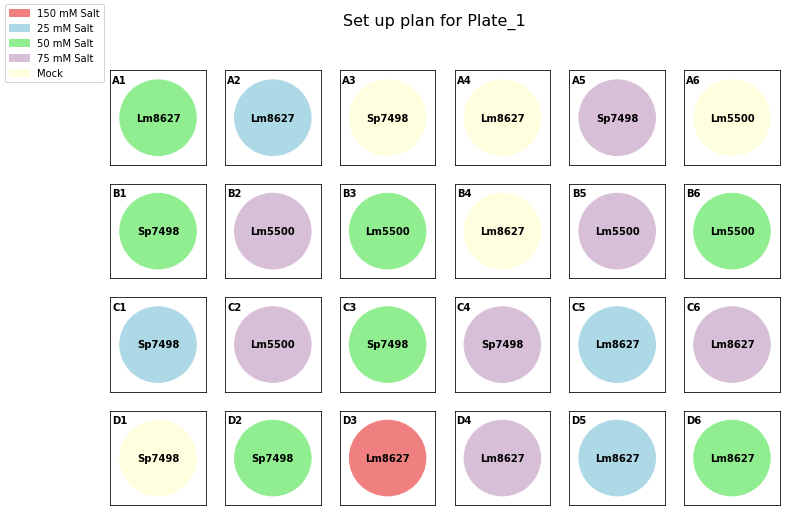

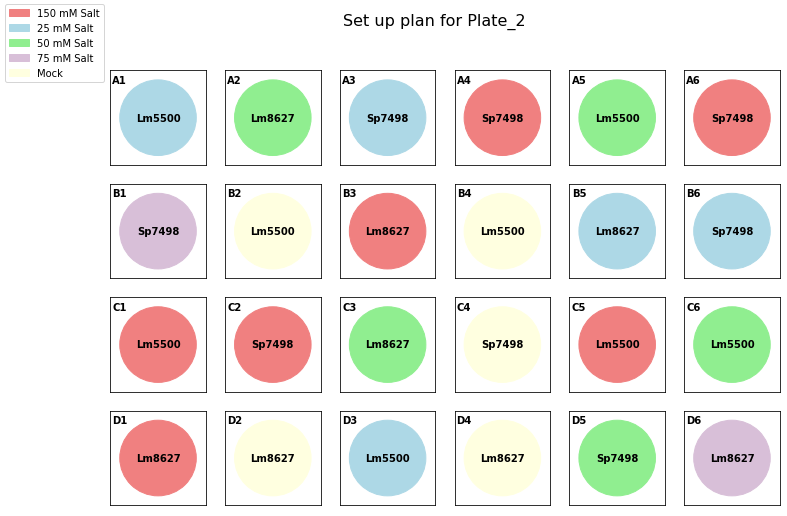

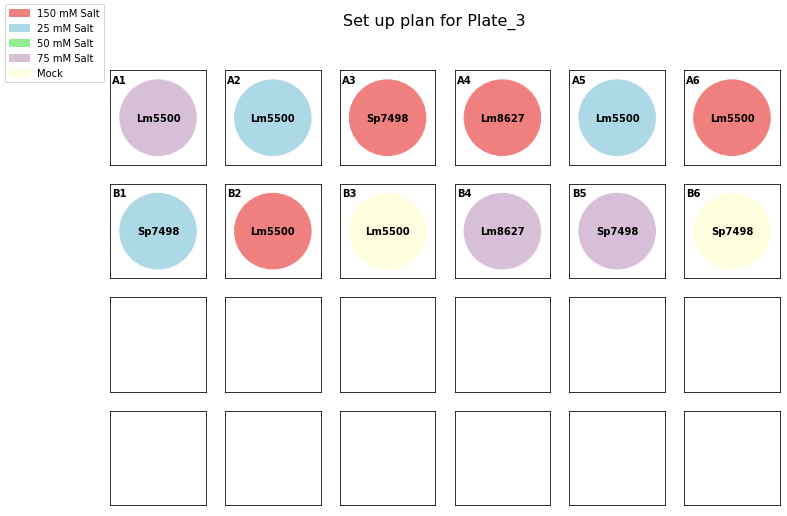

In [4]:
df_with_well_coords = pp.add_well_coords_to_df_from_file(expt_setup_file_path, expt_setup_filename)
exp.visualize_plate_set_up(df_with_well_coords)

## 3. Label 24-well plates and add to machine

#### Label Plates and add plates to machine

In [26]:
df = pd.DataFrame(sample_data)
num_plates = df.Plate.nunique()
print(num_plates)

print("This experiment requires {} 24-well plate(s)".format(num_plates))
print("----")
lst = list(range(1,num_plates + 1))
for n in lst:
    print("Label a plate with experiment ID or initials and 'plate {}'".format(n))
print("----")
print ("Place the 24-well plate(s) in the jubilee".format(num_plates))
print ("Start at position 1 and fill empty plate slots in order")

3
This experiment requires 3 24-well plate(s)
----
Label a plate with experiment ID or initials and 'plate 1'
Label a plate with experiment ID or initials and 'plate 2'
Label a plate with experiment ID or initials and 'plate 3'
----
Place the 24-well plate(s) in the jubilee
Start at position 1 and fill empty plate slots in order


## 2. Dispense media
When prompted insert containers of the relevant sterile media into the input slot on the Jubilee. 

In [27]:
#Retrieve absolute positions of wells from a library and then add those coordinatest to the plate set up dataframe
df = pp.add_well_coords_to_df_from_file(expt_setup_file_path, expt_setup_filename)
print(df)

   genotype        media  condition_replicate    plate_well_id    Plate Well  \
0    Lm8627   50 mM Salt                    2  Plate_1_Well_A1  Plate_1   A1   
1    Lm8627   25 mM Salt                    3  Plate_1_Well_A2  Plate_1   A2   
2    Sp7498         Mock                    2  Plate_1_Well_A3  Plate_1   A3   
3    Lm8627         Mock                    4  Plate_1_Well_A4  Plate_1   A4   
4    Sp7498   75 mM Salt                    4  Plate_1_Well_A5  Plate_1   A5   
5    Lm5500         Mock                    1  Plate_1_Well_A6  Plate_1   A6   
6    Sp7498   50 mM Salt                    4  Plate_1_Well_B1  Plate_1   B1   
7    Lm5500   75 mM Salt                    2  Plate_1_Well_B2  Plate_1   B2   
8    Lm5500   50 mM Salt                    4  Plate_1_Well_B3  Plate_1   B3   
9    Lm8627         Mock                    2  Plate_1_Well_B4  Plate_1   B4   
10   Lm5500   75 mM Salt                    1  Plate_1_Well_B5  Plate_1   B5   
11   Lm5500   50 mM Salt                

In [28]:
#Reorganizes dataframe to create machine instructions sorted by media-type
media_dicts = pp.pull_list_of_well_coord_dicts_by_dfcolumn(df, 'media')
print(media_dicts)

[{'media': '150 mM Salt', 'well-coords': [[67.0, 118.0], [86.0, 78.0], [124.0, 78.0], [67.0, 59.0], [29.0, 40.0], [48.0, 40.0], [105.0, 40.0], [29.0, 21.0], [208.0, 272.0], [227.0, 272.0], [265.0, 272.0], [189.0, 253.0]]}, {'media': '25 mM Salt', 'well-coords': [[48.0, 175.0], [29.0, 137.0], [105.0, 137.0], [105.0, 118.0], [29.0, 78.0], [67.0, 78.0], [105.0, 59.0], [124.0, 59.0], [67.0, 21.0], [189.0, 272.0], [246.0, 272.0], [170.0, 253.0]]}, {'media': '50 mM Salt', 'well-coords': [[29.0, 175.0], [29.0, 156.0], [67.0, 156.0], [124.0, 156.0], [67.0, 137.0], [48.0, 118.0], [124.0, 118.0], [48.0, 78.0], [105.0, 78.0], [67.0, 40.0], [124.0, 40.0], [105.0, 21.0]]}, {'media': '75 mM Salt', 'well-coords': [[105.0, 175.0], [48.0, 156.0], [105.0, 156.0], [48.0, 137.0], [86.0, 137.0], [124.0, 137.0], [86.0, 118.0], [29.0, 59.0], [124.0, 21.0], [170.0, 272.0], [227.0, 253.0], [246.0, 253.0]]}, {'media': 'Mock', 'well-coords': [[67.0, 175.0], [86.0, 175.0], [124.0, 175.0], [86.0, 156.0], [29.0, 11

In [29]:
#Pick up syringe toolhead
port = "/dev/ttyACM0"
m = MachineCommunication(port)
m.toolChange(media_syringe)

In [30]:
# Send machine instructions
for media in media_dicts:
    m.moveTo(x=0,y=0,z=0)
    print(f"Please ensure {media['media']} is available in the machine before continuing.")
    print("Change syringe and/or needle if desired")
    while True:
        value = input("Enter 'YES' to confirm that the correct media is in position")
        if value != "YES":
            print("Please confirm")
        else:
            break
    exp.dispense_to_wells(m, media["well-coords"], dispense_offset, dispenses_per_syringe_fill, media_reservoir, z_dict)

Please ensure 150 mM Salt is available in the machine before continuing.
Change syringe and/or needle if desired
Enter 'YES' to confirm that the correct media is in positionYES
Move to Z = zero
Move to reservoir position
moved to height for aspiration
G1    E81.90 F1000.00
Moved to Z = zero
Hovering over the first well to dispense into
Prepare to dispense
X = 67.0
Y = 118.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 86.0
Y = 78.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 124.0
Y = 78.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 67.0
Y = 59.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 29.0
Y = 40.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 48.0
Y = 40.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 105.0
Y = 40.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 29.0
Y = 21.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 208.0
Y = 272.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 227.0
Y = 272.0
G1    E-5.85 F1000.00
Prepare to dispense
X = 265.0
Y = 272.0
G1    E-5.85 F1

## 5. Transfer duckweed
Place a container filled with fronds of the relevant duckweed type and the machine will attempt to move individual fronds into the relevant wells. After each attempt at filling all wells a camera will take pictures of each well to confirm success and then unsuccessful wells will be reattempted

In [31]:
duckweed_reservoir = [75, 241]
#pop the bed down to avoid any collisions on tool change
m.moveTo(z=50)

In [32]:
# pick up the innoculation loop
m.toolChange(inoculation_loop)
m.moveTo(x=duckweed_reservoir[0], y=duckweed_reservoir[1])

In [33]:
# find suitable z heights to collect, move, and drop-off duckweed
# this can be done using the duet web control interface
collect_height = -34.7 # what height fully immerses the inoculation loop in the reservoir?
move_height = 3 # what height clears all labware to move between reservoir/well plates?
transfer_height = -32 # what height fully immerses the innoculation loop in the well plate?

In [ ]:
# pop the bed down to avoid collisions after probing 
m.moveTo(z=25)

In [34]:
# Inoculation Loop Transfer Test
# The machine will move after running this cell
grouped_df = df.groupby('genotype')
for field_value, sample_df in grouped_df:
    print("Place container of duckweed type **{0}** into jubilee and ensure lid is open".format(field_value))
    print("""Type anything into the input field to confirm that the media is available.
    After this point the Jubilee will begin dispensing""")
    input() 
    count = 0
    for index,s in sample_df.iterrows():
        #move to plate and well
        #move to plate and well
        r = 10
        rx = random.randint(-r, r)
        ry = random.randint(-r, r)

        # move in xy first
        m.moveTo(x=duckweed_reservoir[0] + rx, y=duckweed_reservoir[1] + ry)

        # dip into the reservoir
        m.moveTo(z=collect_height)
        m.dwell(1000) # wait a bit
        
        m.moveTo(z=move_height)
        well = pp.fetch_well_position(s["Plate"][-1], str(s["Well"]))
        m.moveTo(x=well['x'], y=well['y'])
        m.moveTo(z=transfer_height)
        m.dwell(250)
        m.moveTo(z=move_height)

Place container of duckweed type **Lm5500** into jubilee and ensure lid is open
Type anything into the input field to confirm that the media is available.
    After this point the Jubilee will begin dispensing
excelsior
Place container of duckweed type **Lm8627** into jubilee and ensure lid is open
Type anything into the input field to confirm that the media is available.
    After this point the Jubilee will begin dispensing
I hope this one works
Place container of duckweed type **Sp7498** into jubilee and ensure lid is open
Type anything into the input field to confirm that the media is available.
    After this point the Jubilee will begin dispensing
spirodela for the win


In [ ]:
#Manual transfer

grouped_df = df.groupby('genotype')
for field_value, sample_df in grouped_df:
    print("Place container of duckweed type **{0}** into jubilee and ensure lid is open".format(field_value))
    for index,s in sample_df.iterrows():
        plate = s["Plate"]
        well = s["Well"]
        print(f"Transfer {field_value} to plate {plate}, well {well}")
    input()
        #print("Dispensing media of type {0} into {1}, well {2}".format(field_value,s["Plate"], s["Well"]))


Place container of duckweed type **Lm5500** into jubilee and ensure lid is open
Transfer Lm5500 to plate Plate_1, well A6
Transfer Lm5500 to plate Plate_1, well B2
Transfer Lm5500 to plate Plate_1, well B3
Transfer Lm5500 to plate Plate_1, well B5
Transfer Lm5500 to plate Plate_1, well B6
Transfer Lm5500 to plate Plate_1, well C2
Transfer Lm5500 to plate Plate_2, well A1
Transfer Lm5500 to plate Plate_2, well A5
Transfer Lm5500 to plate Plate_2, well B2
Transfer Lm5500 to plate Plate_2, well B4
Transfer Lm5500 to plate Plate_2, well C1
Transfer Lm5500 to plate Plate_2, well C5
Transfer Lm5500 to plate Plate_2, well C6
Transfer Lm5500 to plate Plate_2, well D3
Transfer Lm5500 to plate Plate_3, well A1
Transfer Lm5500 to plate Plate_3, well A2
Transfer Lm5500 to plate Plate_3, well A5
Transfer Lm5500 to plate Plate_3, well A6
Transfer Lm5500 to plate Plate_3, well B2
Transfer Lm5500 to plate Plate_3, well B3

Place container of duckweed type **Lm8627** into jubilee and ensure lid is open

#### Record any extra notes you'd like to add
Write down any notes about today's set up that you would like to be recorded in the set up file 

In [35]:
os.chdir(expt_setup_file_path)
notes = input()
im.add_input_to_json(notes, "Set_up_notes", expt_setup_filename)

Write down any notes about today's set up that you would like to be recorded in the set up file
